# ECD-UY: Technical validation of the Total Household Consumption subset (post-processing)

This notebook presents the code for processing the intermediate file (calculated at ClusterUY) of the technical validation.

In [1]:
# python
import datetime
from typing import List, Tuple, Union
import glob
from os.path import join, exists
from os import makedirs
import warnings
from datetime import datetime, timedelta

# data-science
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print("Pandas version {}".format(pd.__version__))

from dask.system import CPU_COUNT
print("Available cores: {}".format(CPU_COUNT), flush=True)

Populating the interactive namespace from numpy and matplotlib
Pandas version 1.2.1
Available cores: 4


/Users/jp/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Declare the path where the files are located

In [2]:
BASE_PATH = "../../../datasets/"
BASE_DATA_SOURCE = BASE_PATH + "/ECD-UY/total-household-subset--preprocess"

## Setup local dask cluster

In [3]:
print("Generating Dask Client...", flush=True)
client = Client()

Generating Dask Client...


## Number of records per day, by customer

### Load data

In [4]:
df_date_count = dd.read_csv(
    BASE_DATA_SOURCE + '/consumption_date_count.csv',
    delimiter=',',
    header=0,
    dtype={'id': np.int32, 'value': np.int16, 'datetime': str},
    usecols=["id", "datetime", "value"],
)
df_date_count["datetime"] = dd.to_datetime(df_date_count.datetime)

df_date_count.head()

,id,datetime,value
0,13,2019-01-01,96
1,13,2019-01-02,96
2,13,2019-01-03,96
3,13,2019-01-04,96
4,13,2019-01-05,96


In [5]:
df_date_count.id.nunique().compute()

110952

In [6]:
df_date_count.value.describe().compute()

count    5.982334e+07
mean     9.515916e+01
std      5.932536e+00
min      1.000000e+00
25%      9.600000e+01
50%      9.600000e+01
75%      9.600000e+01
max      9.600000e+01
Name: value, dtype: float64

### Records per day

In [7]:
days_per_numerofrecords = df_date_count.value.value_counts().compute()
days_per_numerofrecords.head()

96    57232128
95      520555
94      197934
72      192827
81      184373
Name: value, dtype: int64

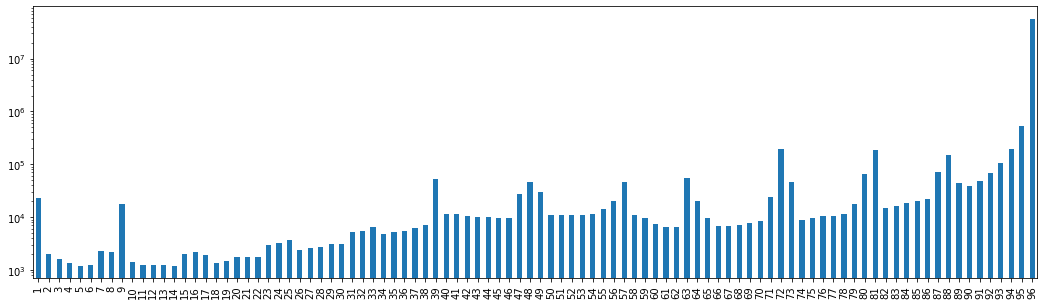

In [8]:
days_per_numerofrecords.sort_index().plot.bar()
plt.yscale('log', nonposy='clip')

In [9]:
bins = pd.cut(days_per_numerofrecords.index, [0, 72, 76, 81, 86, 91, 96])
# days_per_numerofrecords.reset_index().groupby("index")
days_and_records = pd.DataFrame({"num_days": days_per_numerofrecords.groupby(bins).sum()})

days_and_records["share"] = (days_and_records.num_days * 100) / days_and_records.num_days.sum()

days_and_records.sort_index(ascending=False)
# print(days_and_records.sort_index(ascending=False).to_latex())


,num_days,share
"(91, 96]",58122666,97.157168
"(86, 91]",355269,0.593864
"(81, 86]",92690,0.154940
"(76, 81]",289154,0.483346
"(72, 76]",76332,0.127596
"(0, 72]",887232,1.483087


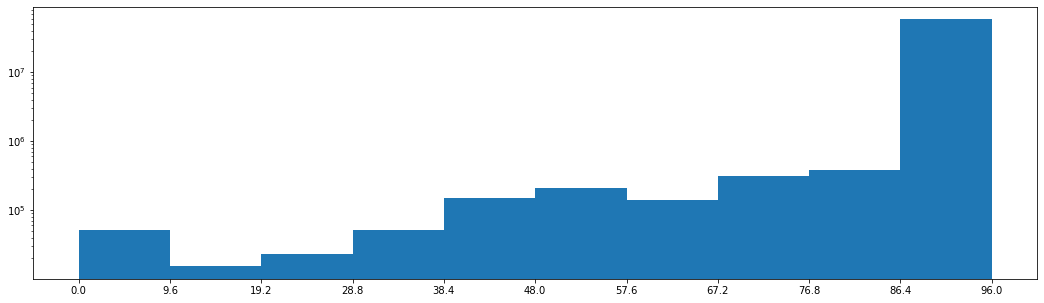

In [10]:
plt.hist(df_date_count.value, bins=[(96/10)*x for x in range(11)])
plt.yscale('log', nonposy='clip')
plt.xticks([(96/10)*x for x in range(11)])
plt.show()

### Days by customer

In [11]:
df_days_per_cust = df_date_count.groupby("id").count().compute()
df_days_per_cust.head()

,datetime,value
id,,
3,557,557
10,554,554
13,650,650
14,675,675
16,577,577


In [12]:
# Take into account only the customers with at least 95% of records per day
df_days_per_cust_95 = df_date_count[
    df_date_count.value > 91  # 96 * 95% = 91.2
].groupby("id").count().compute()
df_days_per_cust_95.head()

,datetime,value
id,,
3,545,545
10,544,544
13,641,641
14,663,663
16,565,565


In [13]:
df_days_per_cust.datetime.describe()

count    110952.000000
mean        539.182196
std          96.898511
min           1.000000
25%         466.000000
50%         536.000000
75%         619.000000
max         677.000000
Name: datetime, dtype: float64

In [14]:
df_days_per_cust_95.datetime.describe()

count    110670.000000
mean        525.188994
std         101.991508
min           1.000000
25%         453.000000
50%         524.000000
75%         606.000000
max         676.000000
Name: datetime, dtype: float64

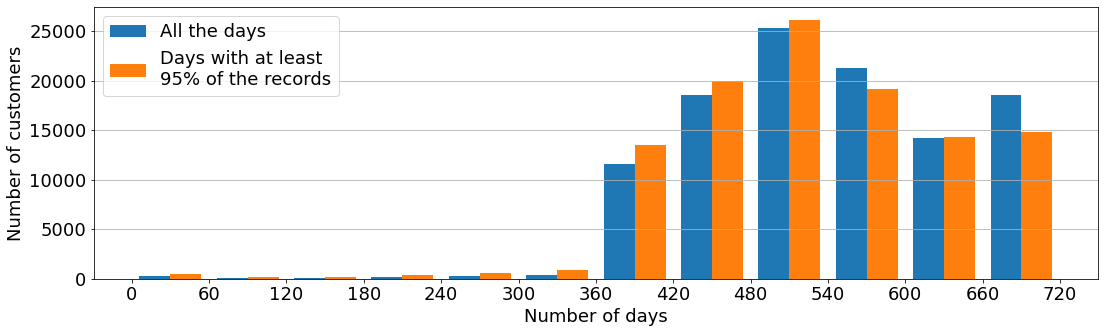

In [15]:
bins = range(0, df_days_per_cust.datetime.max() + 60, 60)

_ = plt.hist([df_days_per_cust.datetime, df_days_per_cust_95.datetime], bins=bins)
_ = plt.legend(["All the days", "Days with at least\n95% of the records"], fontsize=18)
_ = plt.xlabel("Number of days", fontsize=18)
_ = plt.ylabel("Number of customers", fontsize=18)
_ = plt.xticks(bins, fontsize=18)
_ = plt.yticks(fontsize=18)
plt.grid(True, axis='y')

In [16]:
df_days_per_cust.datetime.groupby(pd.cut(df_days_per_cust.datetime, range(0, 731, 60))).count()

datetime
(0, 60]         297
(60, 120]       114
(120, 180]      111
(180, 240]      176
(240, 300]      241
(300, 360]      355
(360, 420]    11870
(420, 480]    18630
(480, 540]    25643
(540, 600]    21010
(600, 660]    14105
(660, 720]    18400
Name: datetime, dtype: int64

In [17]:
max_days = df_days_per_cust.datetime.max()
intervals_index = pd.cut(df_days_per_cust.datetime, list(range(0, max_days, 60)) + [690])
df_daysinterval_per_cust = pd.DataFrame(
    {
        "days_allrecords": df_days_per_cust.datetime.groupby(intervals_index).count(),
        "days_95records": df_days_per_cust_95.datetime.groupby(pd.cut(df_days_per_cust_95.datetime, range(0, max_days, 60))).count(),
    },
    index=intervals_index
)
df_daysinterval_per_cust.fillna(0, inplace=True)

df_daysinterval_per_cust = df_daysinterval_per_cust.sort_index(ascending=False).drop_duplicates()

df_daysinterval_per_cust["days_allrecords_perc"] = (df_daysinterval_per_cust["days_allrecords"]*100)/df_daysinterval_per_cust["days_allrecords"].sum()
df_daysinterval_per_cust["days_95records_perc"]  = (df_daysinterval_per_cust["days_95records"] *100)/df_daysinterval_per_cust["days_95records"].sum()

df_daysinterval_per_cust

,days_allrecords,days_95records,days_allrecords_perc,days_95records_perc
datetime,,,,
"(660, 690]",18400,0.0,16.583748,0.000000
"(600, 660]",14105,14820.0,12.712705,15.347175
"(540, 600]",21010,19032.0,18.936117,19.709004
"(480, 540]",25643,26148.0,23.111796,27.078134
"(420, 480]",18630,20069.0,16.791045,20.782892
"(360, 420]",11870,13768.0,10.698320,14.257754
"(300, 360]",355,858.0,0.319958,0.888521
"(240, 300]",241,590.0,0.217211,0.610987
"(180, 240]",176,368.0,0.158627,0.381090


In [18]:
df_days_per_cust_95.datetime.groupby(pd.cut(df_days_per_cust_95.datetime, [0,365,730], right=False)).count()

datetime
[0, 365)        2809
[365, 730)    107861
Name: datetime, dtype: int64

In [19]:
# max_days = df_days_per_cust.datetime.max()
intervals_index    = pd.cut(df_days_per_cust.datetime,    range(0, 740, 365), right=False)
intervals_index_95 = pd.cut(df_days_per_cust_95.datetime, range(0, 740, 365), right=False)
df_daysinterval_per_cust_yearly = pd.DataFrame(
    {
        "days_allrecords": df_days_per_cust.datetime.groupby(intervals_index).count(),
        "days_95records": df_days_per_cust_95.datetime.groupby(intervals_index_95).count(),
    },
    index=intervals_index
)
df_daysinterval_per_cust_yearly.fillna(0, inplace=True)

df_daysinterval_per_cust_yearly = df_daysinterval_per_cust_yearly.sort_index(ascending=False).drop_duplicates()

df_daysinterval_per_cust_yearly["days_allrecords_perc"] = (df_daysinterval_per_cust_yearly["days_allrecords"]*100)/df_daysinterval_per_cust_yearly["days_allrecords"].sum()
df_daysinterval_per_cust_yearly["days_95records_perc"]  = (df_daysinterval_per_cust_yearly["days_95records"] *100)/df_daysinterval_per_cust_yearly["days_95records"].sum()

df_daysinterval_per_cust_yearly

,days_allrecords,days_95records,days_allrecords_perc,days_95records_perc
datetime,,,,
"[365, 730)",109627,107861,98.80579,97.461823
"[0, 365)",1325,2809,1.19421,2.538177


In [20]:
df_daysinterval_per_cust.sum()

days_allrecords         110952.0
days_95records           96565.0
days_allrecords_perc       100.0
days_95records_perc        100.0
dtype: float64

In [21]:
print(df_daysinterval_per_cust.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  days\_allrecords &  days\_95records &  days\_allrecords\_perc &  days\_95records\_perc \\
datetime   &                  &                 &                       &                      \\
\midrule
(660, 690] &            18400 &             0.0 &             16.583748 &             0.000000 \\
(600, 660] &            14105 &         14820.0 &             12.712705 &            15.347175 \\
(540, 600] &            21010 &         19032.0 &             18.936117 &            19.709004 \\
(480, 540] &            25643 &         26148.0 &             23.111796 &            27.078134 \\
(420, 480] &            18630 &         20069.0 &             16.791045 &            20.782892 \\
(360, 420] &            11870 &         13768.0 &             10.698320 &            14.257754 \\
(300, 360] &              355 &           858.0 &              0.319958 &             0.888521 \\
(240, 300] &              241 &           590.0 &              0.217211 &      

## 15-minutes mean consumption

### Load data

In [22]:
df_15min_mean_consum = dd.read_csv(
    BASE_DATA_SOURCE + '/consumption_15min_mean.csv',
    delimiter=',',
    header=0,
    dtype={'value': np.float, 'datetime': str, 'datetime.1': str},
)
df_15min_mean_consum["hour"] = df_15min_mean_consum.datetime.str.zfill(2) + ":" + df_15min_mean_consum["datetime.1"].str.zfill(2)

df_15min_mean_consum = df_15min_mean_consum.compute()
df_15min_mean_consum.head()

,datetime,datetime.1,value,hour
0,0,0,0.096,00:00
1,0,15,0.091,00:15
2,0,30,0.087,00:30
3,0,45,0.083,00:45
4,1,0,0.079,01:00


### Plot

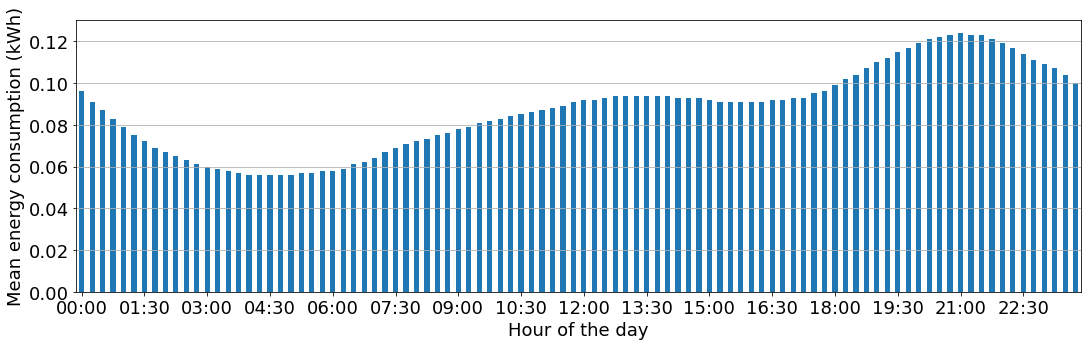

In [23]:
df_15min_mean_consum.plot.bar(x="hour", y="value", legend=False, rot=0)
# _ = plt.legend([], fontsize=18)
_ = plt.xlabel("Hour of the day", fontsize=18)
_ = plt.ylabel("Mean energy consumption (kWh)", fontsize=18)
_ = plt.xticks(range(0, 96, 6), fontsize=18)
_ = plt.yticks(fontsize=18)
plt.grid(True, axis='y')

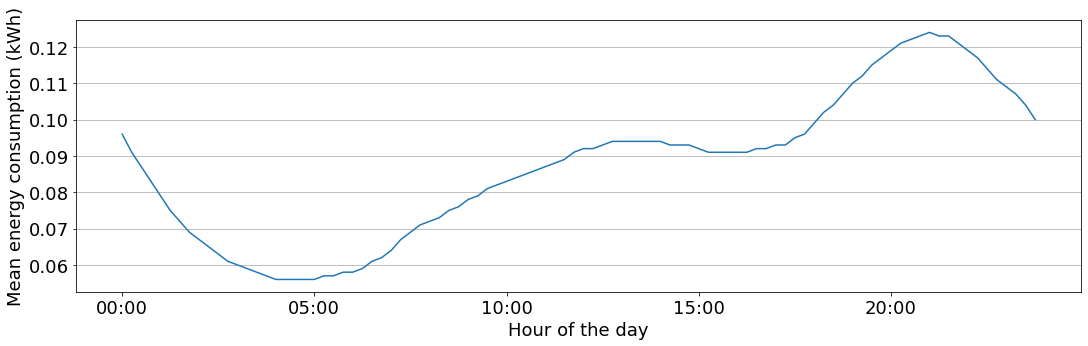

In [24]:
df_15min_mean_consum.plot(x="hour", y="value", legend=False)
_ = plt.xlabel("Hour of the day", fontsize=18)
_ = plt.ylabel("Mean energy consumption (kWh)", fontsize=18)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.grid(True, axis='y')